# Linear NN for images


## Imports


In [2]:
import os 
import pathlib
import torch 
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader


## Constants


In [3]:
IMG_HEIGTH = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3


CLASS_NAMES = ["display", "dandelion", "roses", "sunflowers", "tulips"]


## TO DO


1. Load the dataset
2. JPEG to rgb
3. scale to 0-1
4. resize to 244*244*3
5. sanity check


In [4]:
# !pip install scipy
    

In [5]:
# The dataset we are going to use is Oxford Flowers 102
# we will use the torchvision.datasets to load the dataset 
# intially the torchvision.datasets.Flower102 return a image path not tensors 
# we will use the loader = torchvision.io.decode_image to convert the raw bytes stream to tensor in CHW format
# the root path - this check if the dataset is already present or else do we need to dowload it 

# We will also need to transform the image as per our requirements 

# def one_hot_encode(x):
#     return F.one_hot(torch.tensor(x), num_classes=102)

flower_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((IMG_HEIGTH, IMG_WIDTH)),
    torchvision.transforms.ToTensor(),
])

train_dataset = torchvision.datasets.Flowers102(
    root = "Data/train/", 
    download=True,
    split= "train",
    # loader= torchvision.io.decode_image,
    transform= flower_transform, 
    # target_transform= one_hot_encode
)




In [6]:
train_loader = DataLoader(
    dataset= train_dataset,
    batch_size= 16,
    shuffle= True, 
    num_workers= 0,
)


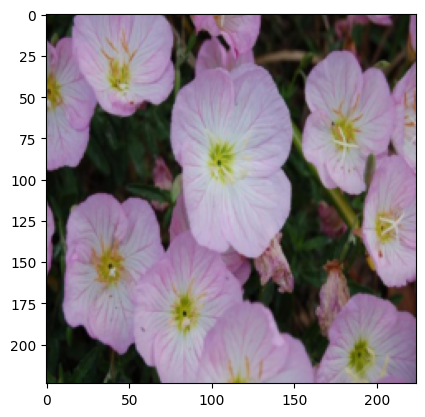

In [7]:
x = torch.tensor(0)
for img, label in train_dataset:
    plt.imshow(img.permute(1, 2, 0).numpy())
    break


In [8]:
# Lets build a linear model for image classification 
# Flatten the image 
# Dense fully connected layer
# Softmax 



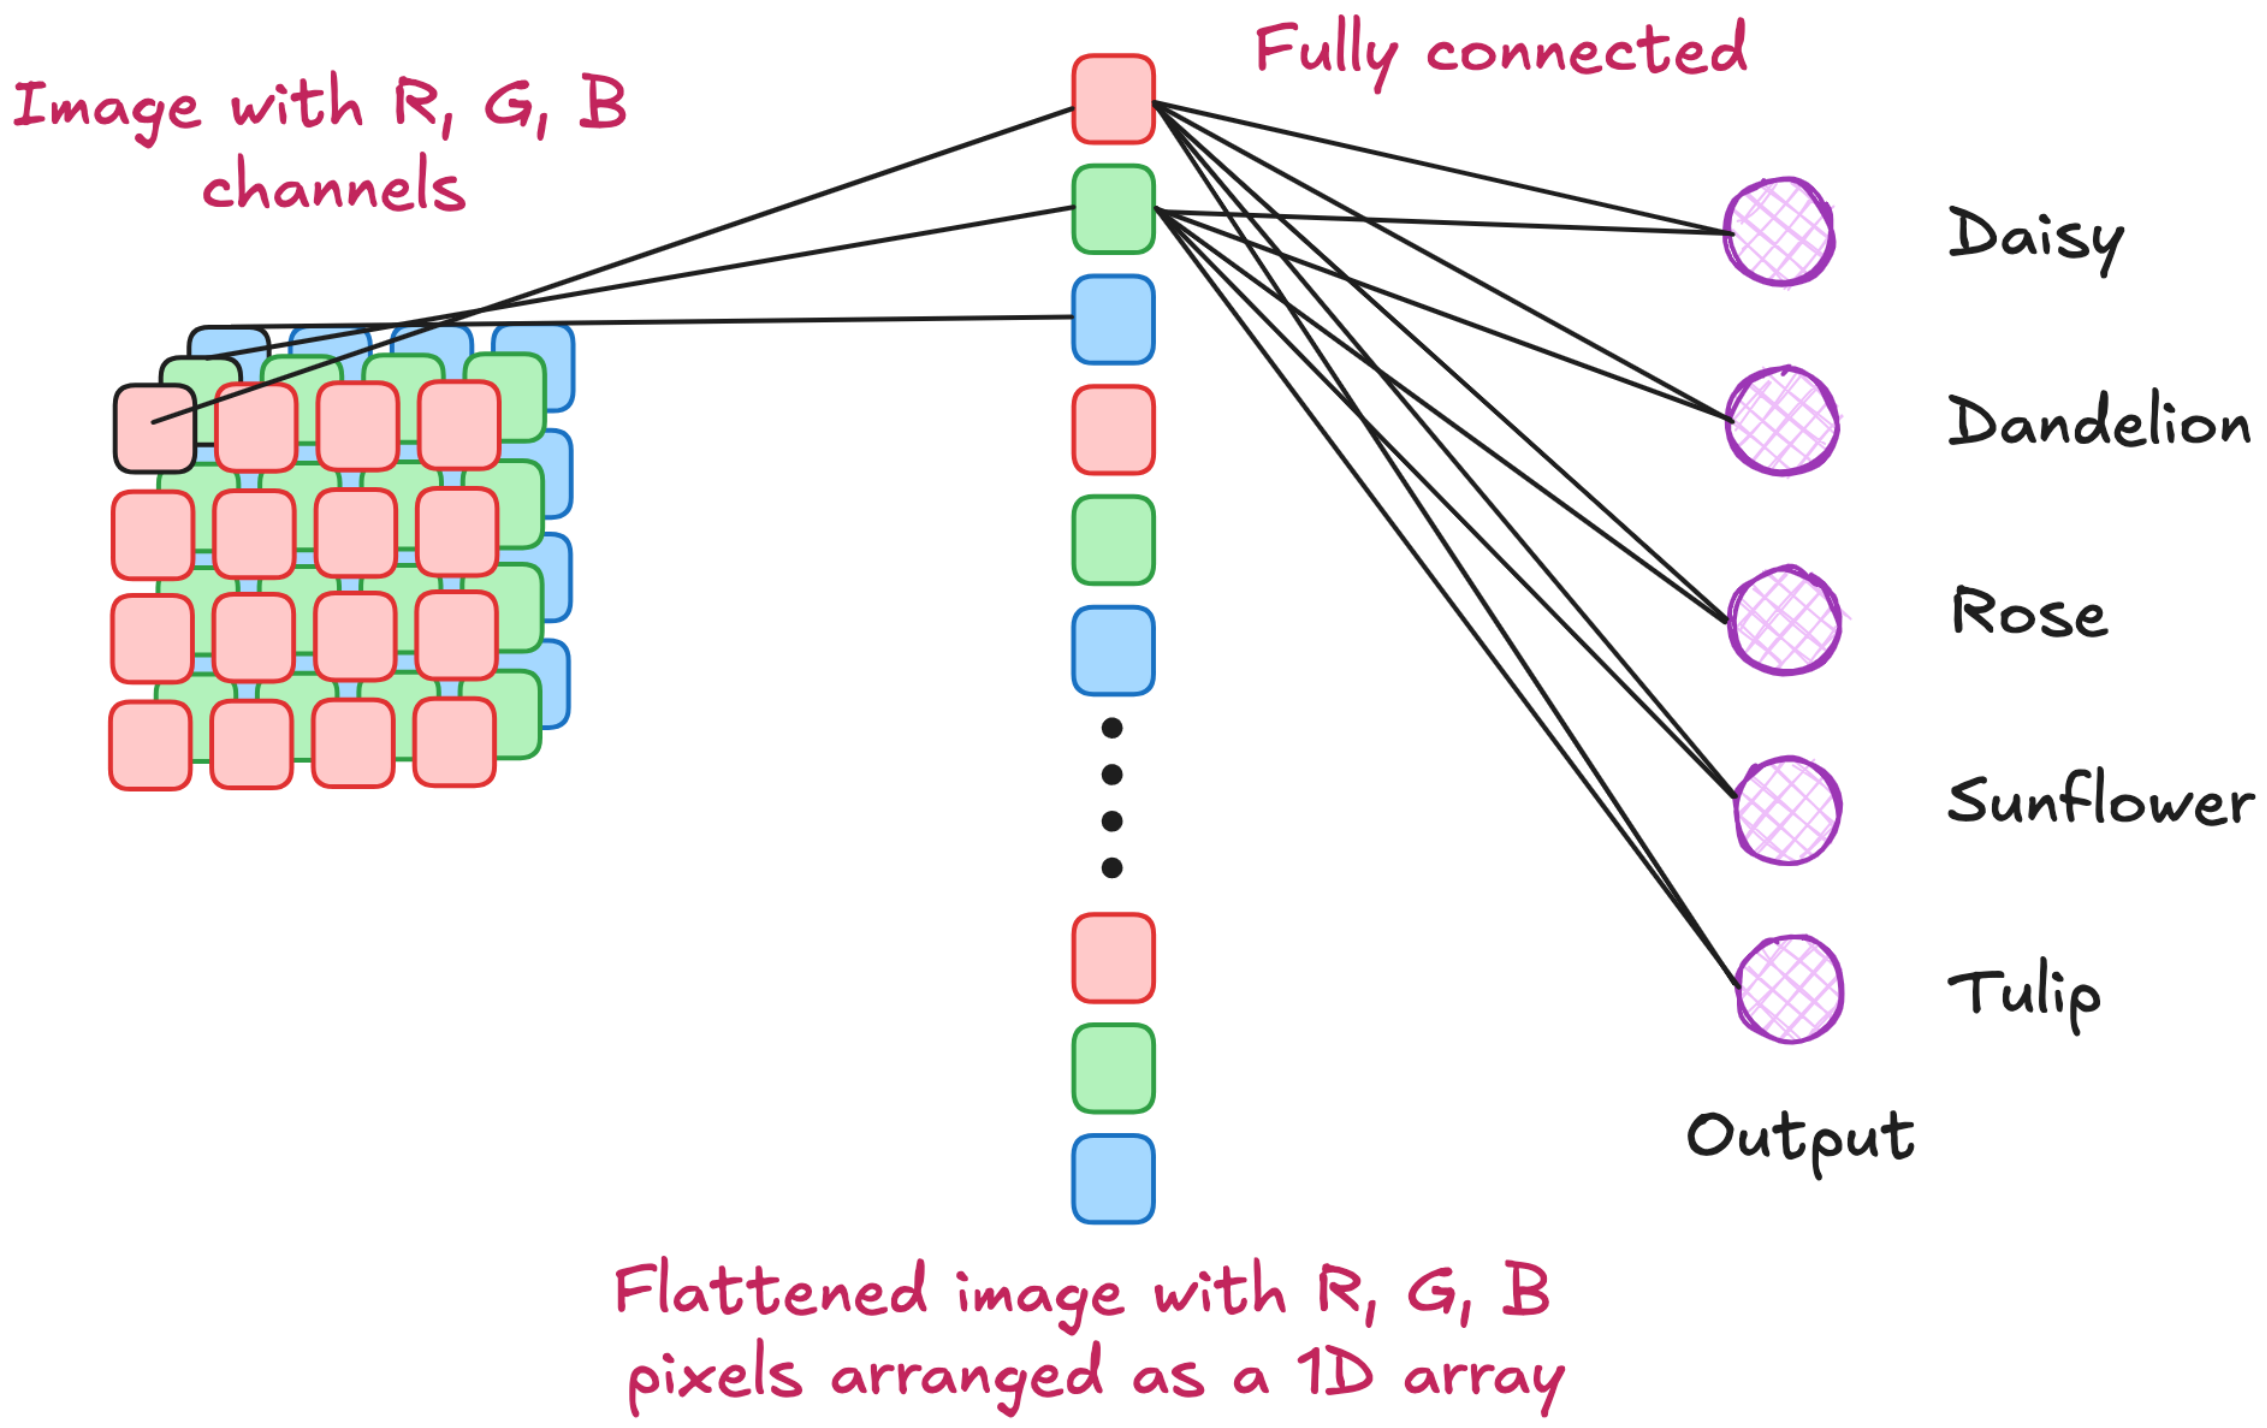

In [10]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [11]:
class ModelV1(nn.Module):
    def __init__(self, in_features, out_features, bias=True, device=DEVICE):
        super().__init__()
        self.Linear = nn.Linear(
            in_features= in_features,
            out_features= out_features, 
            bias= bias,
            device= device
        )
        
    def forward(self, x):
        pass


In [ ]:
model = ModelV1(
    in_features=224*224*3, 
    out_features=102,
    bias=True,
    device=DEVICE
)
model


ModelV1(
  (Linear): Linear(in_features=150528, out_features=102, bias=True)
)